In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:75% !important; }</style>"))

In [2]:
import sys

sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# # Import TensorLy
# import tensorly as tl
# from tensorly.tucker_tensor import tucker_to_tensor
# from tensorly.random import check_random_state

In [3]:
sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random


In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Linux-5.4.0-54-generic-x86_64-with-glibc2.10
Python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
NumPy 1.19.2
SciPy 1.5.2
TensorLy 0.5.0
PyTorch 1.7.0


In [5]:
tl.set_backend('pytorch')

In [6]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)
device = 'cuda:0'
# device = 'cpu'

In [7]:
# ### import data

# dir_factors_np = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
# fileName_factors_np = f'factors_np.npy'
# path_factors_np = f'{dir_factors_np}/{fileName_factors_np}'
# factors_np = np.load(path_factors_np , allow_pickle=True)
# print(f'inputTensor shape: {factors_np.shape}')

In [8]:
### import data

dir_inputTensor = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
fileName_inputTensor = f'Sxx_allPixels.npy'
path_inputTensor = f'{dir_inputTensor}/{fileName_inputTensor}'
inputTensor = np.load(path_inputTensor)
print(f'inputTensor shape: {inputTensor.shape}')

inputTensor shape: (820, 49, 29323, 2)


In [9]:
# # tensor = tl.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# tensor = torch.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# # tensor = tl.tensor(tensor[ , device=device , requires_grad=True)

import gc

del inputTensor
gc.collect()

In [10]:
rank_toUse = 6
ranks = [rank_toUse , rank_toUse, rank_toUse , rank_toUse]
# core = tl.tensor(rng.random_sample(ranks), device=device, requires_grad=True)

# factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])),
#                  device=device, requires_grad=True) for i in range(tl.ndim(tensor))]

weights = tl.tensor(np.ones(rank_toUse) , device=device, dtype=tl.float32, requires_grad=True)
# weights = tl.tensor(np.ones(rank_toUse) , device="cuda:0", dtype=tl.float32, requires_grad=True)

In [11]:
from torch.utils.data import Dataset, DataLoader
import copy
   
### Make dataset objects

class make_batchSlices_dataObj(Dataset):
    def __init__(self, input_tensor):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = input_tensor
    def __len__(self):
        return self.tensor_full.shape[2]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        tensor_slice = torch.tensor( self.tensor_full[:,:,idx,:] , dtype=torch.float32 , device=device , requires_grad=True )
        return tensor_slice , idx
    
# class make_batchFilaments_dataObj(Dataset):
#     def __init__(self, input_tensor):
#         """
#         Args:
#             input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
#         """
#         self.tensor_full = input_tensor
#         self.shape_tensor = self.tensor_full.shape
#     def __len__(self):
#         return self.shape_tensor[0] * self.shape_tensor[1] * self.shape_tensor[3]
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()     
#         idx_subscripts = np.unravel_index([idx], (batchFilaments_dataObj.shape_tensor[0] , batchFilaments_dataObj.shape_tensor[1] , batchFilaments_dataObj.shape_tensor[3]) , order='F') # order='F' necessary to make it (dim 0 , dim1 , dim2, ...)
#         idx_subscripts = np.array(idx_subscripts)[:,0]
        
#         tensor_filament = torch.tensor( self.tensor_full[idx_subscripts[0],idx_subscripts[1],:,idx_subscripts[2]] , dtype=torch.float32 , device=device , requires_grad=True )
#         return tensor_filament , idx , idx_subscripts

In [12]:
batch_size = 7000

batchSlices_dataObj = make_batchSlices_dataObj(inputTensor)
dataloader_batchSlices = DataLoader(batchSlices_dataObj, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=0, pin_memory=False)

# batchFilaments_dataObj = make_batchFilaments_dataObj(inputTensor)
# dataloader_batchFilaments = DataLoader(batchFilaments_dataObj, batch_size=1, drop_last=True,
#                         shuffle=True, num_workers=0)

In [ ]:
#basic libary
import torch

import torch.nn as nn
import torch.optim as optim

import time
# torch.multiprocessing.set_start_method('spawn')# good solution !!!!

##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0,eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self):
        super(NTF, self).__init__()

#         self.factors = nn.ParameterList([nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[i], ranks[i])) , device='cuda:0').double(), requires_grad=True) for i in range(tensor.ndim)])
        
#         self.factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])), device='cuda:0', requires_grad=True) for i in range(tl.ndim(tensor))]

           
        self.factors1 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[0], ranks[0])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors2 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[1], ranks[1])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors3 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[2], ranks[2])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors4 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[3], ranks[3])) , dtype=tl.float32 , device=device), requires_grad=True) 
        
    def forward(self , stage , idx):
#             tmp = list((self.factors3.relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:].relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:] , self.factors1 , self.factors2 , self.factors4))
        tmp = list((prox_plus(self.factors3[idx,:]) , prox_plus(self.factors1) , prox_plus(self.factors2) , prox_plus(self.factors4)))
        
        

        
#         reconstruction = prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
        reconstruction = tl.cp_tensor.cp_to_tensor((weights, tmp))
        return reconstruction


            
            
print('Start training on Task 1...')

ntf_obj = NTF()
ntf_obj.cuda()
loss_rolling=[] #collect loss

n_epoch =5000
# lr = 0.005
lr = 0.02
# lr = 0.2
penalty_L1 = 0.1
penalty_L2 = 0.1
weight_decay = 0.2
# loss_fn = nn.MSELoss(reduction='sum')


# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
optimizer    = torch.optim.Adam(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4))  ,  lr=lr , weight_decay=weight_decay)
num_repeats_per_batch = 200

length_factors3 = ntf_obj.factors3.shape[0]
for epoch in range(n_epoch):
#     torch.cuda.empty_cache()
    stage='batchSlices'
    ntf_obj.factors1.requires_grad = True
    ntf_obj.factors2.requires_grad = True
    ntf_obj.factors3.requires_grad = True
    ntf_obj.factors4.requires_grad = True
    for iter_batchSlices , (tensor_batchSlices, idx_batchSlices)   in   enumerate(dataloader_batchSlices):
        idx_batchSlices_bool = np.in1d(np.arange(length_factors3) , idx_batchSlices)
        factors3_frozen = copy.deepcopy(ntf_obj.factors3.detach())
        for iter_repeats in range(num_repeats_per_batch):
            Y_ = ntf_obj(stage , idx_batchSlices)
            loss = tl.norm((Y_ - tensor_batchSlices), 2)
#             # squared l2 penalty on the factors of the decomposition
#             for param in ntf_obj.parameters():
#         #         loss = loss + penalty_L2 * param.data.pow(2).sum()
#         #         loss = loss + penalty_L2 * param.data.abs().sum()
#                 l1_regularization = penalty_L1 * torch.norm(param.data, 1)
#                 l2_regularization = penalty_L2 * (torch.norm(param.data, 2)**2)
#                 loss = loss + l1_regularization + l2_regularization
            ntf_obj.zero_grad() # need to clear the old gradients
            loss.backward(retain_graph=True)
            optimizer.step()

            loss_rolling.append(loss.detach())
            if(iter_repeats%50==0):
        #         print(loss)
        #         print(f'loss = {loss.cpu().detach().numpy()[None][0]}')
        #             rec_error = loss/tl.norm(goal_tensor, 2)
        #         rec_error = loss/tl.norm(val, 2)
                rec_error = 0
        #             print("Epoch {}  ,  Rec. error: {}  ,  loss: {}".format(epoch, rec_error, loss))
                print("Epoch: {}  ,  Batch position: {}/{}  ,  Repeat Num: {}  Rec. error: {}  ,  loss: {}".format(epoch, iter_batchSlices , length_factors3/batch_size , iter_repeats , rec_error , loss))
        with torch.no_grad():
            ntf_obj.factors3[~idx_batchSlices_bool,:] = factors3_frozen[~idx_batchSlices_bool,:]

Start training on Task 1...
Epoch: 0  ,  Batch position: 0/4.189  ,  Repeat Num: 0  Rec. error: 0  ,  loss: 27293.671875
Epoch: 0  ,  Batch position: 0/4.189  ,  Repeat Num: 50  Rec. error: 0  ,  loss: 18144.099609375
Epoch: 0  ,  Batch position: 0/4.189  ,  Repeat Num: 100  Rec. error: 0  ,  loss: 17186.505859375
Epoch: 0  ,  Batch position: 0/4.189  ,  Repeat Num: 150  Rec. error: 0  ,  loss: 16634.900390625
Epoch: 0  ,  Batch position: 1/4.189  ,  Repeat Num: 0  Rec. error: 0  ,  loss: 66782.296875
Epoch: 0  ,  Batch position: 1/4.189  ,  Repeat Num: 50  Rec. error: 0  ,  loss: 17946.1015625
Epoch: 0  ,  Batch position: 1/4.189  ,  Repeat Num: 100  Rec. error: 0  ,  loss: 17396.94140625
Epoch: 0  ,  Batch position: 1/4.189  ,  Repeat Num: 150  Rec. error: 0  ,  loss: 17287.11328125
Epoch: 0  ,  Batch position: 2/4.189  ,  Repeat Num: 0  Rec. error: 0  ,  loss: 51960.60546875
Epoch: 0  ,  Batch position: 2/4.189  ,  Repeat Num: 50  Rec. error: 0  ,  loss: 17586.9453125
Epoch: 0  ,  B

In [23]:
with torch.no_grad():
    ntf_obj.factors3[~idx_batchSlices,:] = factors3_frozen[~idx_batchSlices,:]

factors_np = list(np.zeros(4))
for iter , param in enumerate(ntf_obj.parameters()):
    factors_np[iter] = param.relu().cpu().detach().numpy()
    

In [ ]:
# for ii , (tensor_slice , idx , idx_subscripts) in enumerate(dataloader_batchFilaments):
#     print(idx_subscripts)

<IPython.core.display.Javascript object>


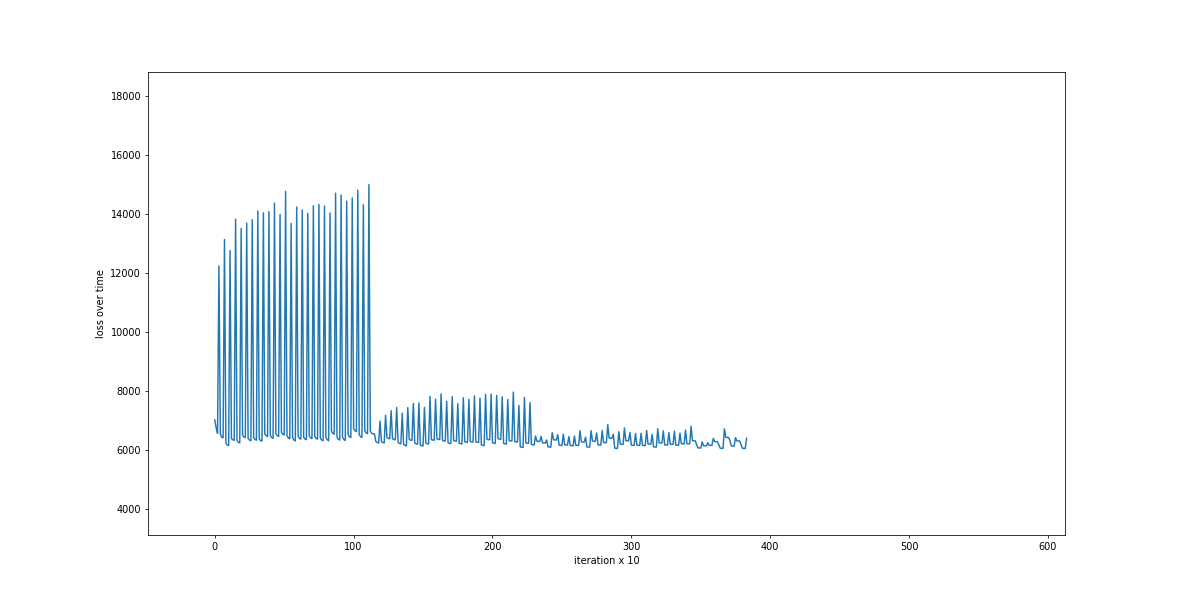

Final loss on Task 1: 
tensor(6402.2852, device='cuda:0')


In [25]:
%matplotlib notebook
plt.figure()
plt.plot(loss_rolling[1:])
plt.ylabel('loss over time')
plt.xlabel('repeat (sub-iteration) #')
plt.show()

print('Final loss on Task 1: ')
print(loss_rolling[-1])

<IPython.core.display.Javascript object>


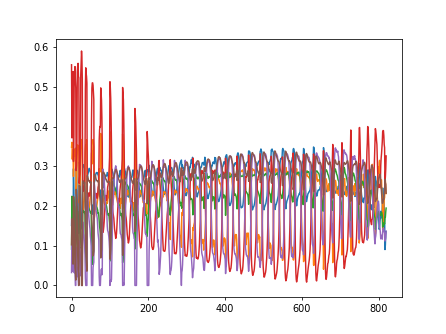

<IPython.core.display.Javascript object>


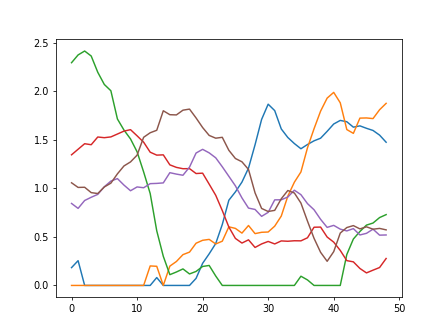

<IPython.core.display.Javascript object>


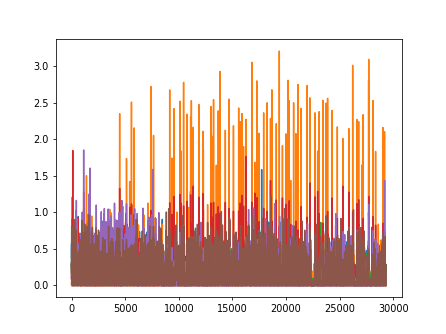

<IPython.core.display.Javascript object>


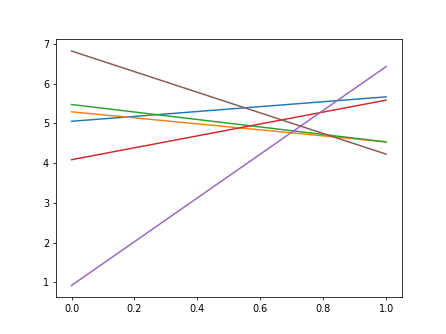

In [24]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(factors_np[0])
plt.figure()
plt.plot(factors_np[1])
plt.figure()
plt.plot(factors_np[2])
plt.figure()
plt.plot(factors_np[3])
